In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, GAE, GATConv, DeepGraphInfomax
from torch_geometric.utils import train_test_split_edges
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import pytorch_lightning as pl
from argparse import Namespace

import ast
import pandas as pd
import numpy as np
import pickle
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from scipy.spatial.distance import jensenshannon, cosine, pdist

from tqdm.auto import tqdm

import os
import sys
sys.path.append('..')

dev = torch.device('cuda:0')
torch.cuda.is_available()

True

In [2]:
prot_path = '../data/lc_embeddings_raw.pkl'
prot_dict = {}
with open(prot_path, 'rb') as f:
    prot_dict = pickle.load(f)
    
prot_dict['Perturbation'] = np.zeros((384,))
prot_dict['IKBKAP'] = np.zeros((384,))
prot_dict['WHSC1'] = np.zeros((384,))
prot_dict['ADRBK1'] = np.zeros((384,))
prot_dict['FIGF'] = np.zeros((384,))
prot_dict['FAM175A'] = np.zeros((384,))
prot_dict['PARK2'] = np.zeros((384,))
prot_dict['NKX3~1'] = np.zeros((384,))
prot_dict['ERBB2IP'] = np.zeros((384,))

shapes_dict = {
    'num_prot_features' : 385,
    'num_edge_features' : 1
}

In [3]:
np.array(prot_dict['LCK']).shape

(384,)

In [4]:
files = '../../snac_data/file_info.csv'
finfo = pd.read_csv(files)
finfo

,Unnamed: 0,files_combined,sig_id,count.x,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,...,distil_nsample,quality,myc_ranks,median_drug_ranks,counts,primary_site,rdkit,atoms,count.y,emb
0,1,graphs_combined/AML001_CD34_24H_BRD-A19500257_...,AML001_CD34_24H_BRD-A19500257_1.11111,100,BRD-A19500257,geldanamycin,trt_cp,CD34,1.11111,µM,...,2,1,59,57.0,61,bone,COC1=C2CC(C)CC(OC)C(O)C(C)/C=C(\C)C(OC(N)=O)C(...,40.0,1.0,AML001_CD34_24H_BRD-A19500257_1.11111_emb_1
1,2,graphs_combined/AML001_CD34_24H_BRD-A19500257_...,AML001_CD34_24H_BRD-A19500257_1.11111,100,BRD-A19500257,geldanamycin,trt_cp,CD34,1.11111,µM,...,2,1,59,57.0,61,bone,COC1=C2CC(C)CC(OC)C(O)C(C)/C=C(\C)C(OC(N)=O)C(...,40.0,1.0,AML001_CD34_24H_BRD-A19500257_1.11111_emb_10
2,3,graphs_combined/AML001_CD34_24H_BRD-A19500257_...,AML001_CD34_24H_BRD-A19500257_1.11111,100,BRD-A19500257,geldanamycin,trt_cp,CD34,1.11111,µM,...,2,1,59,57.0,61,bone,COC1=C2CC(C)CC(OC)C(O)C(C)/C=C(\C)C(OC(N)=O)C(...,40.0,1.0,AML001_CD34_24H_BRD-A19500257_1.11111_emb_100
3,4,graphs_combined/AML001_CD34_24H_BRD-A19500257_...,AML001_CD34_24H_BRD-A19500257_1.11111,100,BRD-A19500257,geldanamycin,trt_cp,CD34,1.11111,µM,...,2,1,59,57.0,61,bone,COC1=C2CC(C)CC(OC)C(O)C(C)/C=C(\C)C(OC(N)=O)C(...,40.0,1.0,AML001_CD34_24H_BRD-A19500257_1.11111_emb_11
4,5,graphs_combined/AML001_CD34_24H_BRD-A19500257_...,AML001_CD34_24H_BRD-A19500257_1.11111,100,BRD-A19500257,geldanamycin,trt_cp,CD34,1.11111,µM,...,2,1,59,57.0,61,bone,COC1=C2CC(C)CC(OC)C(O)C(C)/C=C(\C)C(OC(N)=O)C(...,40.0,1.0,AML001_CD34_24H_BRD-A19500257_1.11111_emb_12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502734,502735,graphs_combined/RAD001_HCC515_6H_BRD-K84937637...,RAD001_HCC515_6H_BRD-K84937637-001-03-2_0.0137,100,BRD-K84937637,sirolimus,trt_cp,HCC515,0.01370,µM,...,3,1,27,27.0,30,lung,NaN,NaN,NaN,RAD001_HCC515_6H_BRD-K84937637-001-03-2_0.0137...
502735,502736,graphs_combined/RAD001_HCC515_6H_BRD-K84937637...,RAD001_HCC515_6H_BRD-K84937637-001-03-2_0.0137,100,BRD-K84937637,sirolimus,trt_cp,HCC515,0.01370,µM,...,3,1,27,27.0,30,lung,NaN,NaN,NaN,RAD001_HCC515_6H_BRD-K84937637-001-03-2_0.0137...
502736,502737,graphs_combined/RAD001_HCC515_6H_BRD-K84937637...,RAD001_HCC515_6H_BRD-K84937637-001-03-2_0.0137,100,BRD-K84937637,sirolimus,trt_cp,HCC515,0.01370,µM,...,3,1,27,27.0,30,lung,NaN,NaN,NaN,RAD001_HCC515_6H_BRD-K84937637-001-03-2_0.0137...
502737,502738,graphs_combined/RAD001_HCC515_6H_BRD-K84937637...,RAD001_HCC515_6H_BRD-K84937637-001-03-2_0.0137,100,BRD-K84937637,sirolimus,trt_cp,HCC515,0.01370,µM,...,3,1,27,27.0,30,lung,NaN,NaN,NaN,RAD001_HCC515_6H_BRD-K84937637-001-03-2_0.0137...


In [5]:
samples = '../data/samples_all.csv'
samples = pd.read_csv(samples)
samples = samples.path_list.to_numpy()
samples = set(samples)
non_samples = set(finfo.files_combined).difference(samples)

In [6]:
fnames = np.random.choice(list(non_samples), 50_000)
X, val = train_test_split(fnames, test_size=0.2)
len(val)

10000

In [7]:
sample =finfo.files_combined[100]
sample

'graphs_combined/AML001_CD34_24H_BRD-A72796238_0.37037/graph_1.csv'

In [8]:
df = pd.read_csv('../../snac_data/' + sample)
df.head()

,Unnamed: 0,node1,sign,node2,activity1,activity2
0,1,AKT1,1,PRKACA,1,1
1,2,MAPK14,1,FOXO3,1,1
2,3,MAPK1,-1,FOXO3,-1,1
3,4,PPP2CA,1,FOXO3,1,1
4,5,TRAF6,1,AKT1,1,1


In [9]:
def csv2edge(path, prot_dict, shapes_dict):
    """
        Reads the csv file and after converting it to a DataFrame, creates the edge matrix in the appropriate
        COO format requested by torch geometric. Afterwards, creates the x tensor of the node features taken
        from the prot_dict dictionary created.
        Inputs 
            path: path to graph csv file
            prot_dict: protein features dictionary
            shapes_dict: dictionary specifying the shapes of each graph with keys
                        'max_prots', 'num_prot_features', 'num_edge_features'
        Outputs 
            edge_index: edge matrix tensor in COO format : (2, num_edges)
            x: node features tensor with shape (num_nodes, num_features)
    """
    npf = 'num_prot_features' in shapes_dict
    nef = 'num_edge_features' in shapes_dict
    assert npf and nef
    
    graph = pd.read_csv('../../snac_data/' + path)
    node1 = graph.node1.to_numpy()
    node2 = graph.node2.to_numpy()
    sign = graph.sign.to_numpy()
    
    unique = np.unique(np.concatenate((node1, node2)))
    
    node_dict = {}
    node_act = {}
    
    n1a1 = graph[['node1','activity1']]
    n1a1.columns = ['node', 'act']
    n2a2 = graph[['node2','activity2']]
    n2a2.columns = ['node', 'act']
    na = pd.concat([n1a1,n2a2])
    na = na.drop_duplicates('node').sort_values(by='node')
    
    for idx, node in enumerate(unique):
            node_dict[node] = idx
            
    node1 = [node_dict[n] for n in node1]
    node2 = [node_dict[n] for n in node2]
    n1 = np.reshape(node1, (len(node1), 1))
    n2 = np.reshape(node2, (len(node2), 1))
    sign = np.reshape(sign, (len(sign), 1))
    
    # For the edge index matrix in the appropriate coo format
    pairs_1 = np.hstack((n1, n2))
    pairs_ws = np.hstack((pairs_1, sign))
    
    pairs_1 = pairs_1[np.argsort(pairs_1[:,0])]
    pairs_ws = pairs_ws[np.argsort(pairs_ws[:,0])]
    sign = pairs_ws[:, 2]
    sign = np.reshape(sign, (len(sign), 1))
    
    pairs_flipped = np.flip(pairs_1, axis=1)
    pairs_flipped_ws = np.hstack((pairs_flipped, sign))
    
    pairs = np.concatenate((pairs_ws, pairs_flipped_ws))
    pairs = pairs[np.argsort(pairs[:, 0])]
    edge_index = pairs[:, [0,1]]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    # Creating the node attributes tensor using the prot_dict and shapes_dict files
    num_prot_features, num_edge_features = [p for p in shapes_dict.values()]
    
    max_prots = len(unique)
    x = np.zeros((max_prots, num_prot_features))
    
    for idx, node in enumerate(unique):
        x[idx] = np.hstack((prot_dict[node], na['act'].to_numpy()[idx]))

    x_scale = MaxAbsScaler()
    x = x_scale.fit_transform(x)
    x = torch.tensor(x, dtype=torch.float) 
    
    # Creating the edge_features matrix for the edges present in the graph
    edge_feats = pairs[:, 2]
    edge_feats = edge_feats.reshape(-1,1)
    scaler = MinMaxScaler()
    edge_feats = scaler.fit_transform(edge_feats)
    edge_feats = edge_feats.reshape(-1)
    edge_feats = torch.tensor(edge_feats, dtype=torch.float)
    
    return edge_index, x, edge_feats
    
edge_index, x, edge_feats = csv2edge(sample, prot_dict, shapes_dict)

In [10]:
data_s= Data(edge_index=edge_index, x=x, edge_attr=edge_feats).to(dev)

In [11]:
data_s.edge_index

tensor([[ 0,  0,  0,  0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  5,  5,  5,  5,
          5,  6,  7,  7,  8,  9, 10, 11, 12, 12, 12, 13, 14, 14, 14, 15, 15, 15,
         16, 17, 18, 18, 18, 18, 18, 18, 19, 20, 20, 20, 21, 22, 23, 24, 25, 26,
         27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 29,
         29, 30, 30, 31, 32, 32, 32, 33, 34, 34, 34, 35, 35, 36, 36, 37, 37, 37,
         37, 37, 38, 38, 38, 38, 39, 39, 39, 40, 41, 41, 42, 43, 44, 45, 46, 46,
         46, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49, 49, 49, 50, 51, 52],
        [38, 12, 48, 18, 35, 20, 28, 25, 11,  9, 43, 27, 13, 27, 30, 46, 27, 22,
         42, 45, 47, 52, 47,  3, 41,  2,  0, 34, 28,  4, 36, 23, 34, 27, 37, 28,
         28, 18, 38, 32, 20,  0, 29, 17, 27,  1, 28, 18, 28,  5, 14, 39,  2, 32,
         34, 19, 46,  4, 35, 37, 15,  5,  3, 48, 37, 20, 12, 15,  1, 21, 16, 18,
         49,  5, 48, 38, 26, 44, 18, 49, 12, 14, 27,  0, 27, 49, 14, 27, 39, 41,
         15, 28,  0, 51, 31, 18, 24

In [12]:
data_s.x

tensor([[ 0.1132, -0.6491, -0.0199,  ...,  0.2326,  0.4822,  1.0000],
        [-0.6013,  0.2353, -0.1208,  ...,  0.2870,  0.3136,  1.0000],
        [ 0.1962, -0.3067, -0.0913,  ...,  0.0516, -0.0867,  1.0000],
        ...,
        [-0.1299, -0.0685, -0.0358,  ...,  0.0636,  0.9734, -1.0000],
        [-0.6466,  0.1432,  0.6966,  ..., -0.4928, -0.1750, -1.0000],
        [-0.3057, -0.1427, -0.1181,  ...,  0.0813, -0.2522,  1.0000]],
       device='cuda:0')

# Creating the DataLoader

In [13]:
class SNDataset(Dataset):
    def __init__(self, fnames, prot_dict, shape_dict):
        super(SNDataset, self).__init__()
        self.fnames = fnames
        self.pd = prot_dict
        self.sd = shape_dict 
        
    def len(self):
        return len(self.fnames)
        
    def get(self, idx):
        edge_index, x, edge_attr = csv2edge(self.fnames[idx], self.pd, self.sd)
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return data

In [14]:
train_data = SNDataset(X, prot_dict, shapes_dict)
train_loader = DataLoader(train_data, batch_size=64)

val_data = SNDataset(val, prot_dict, shapes_dict)
val_loader = DataLoader(val_data, batch_size=32)

# Creating an Autoencoder Pytorch model

In [15]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels)
        self.act = torch.nn.PReLU()
        
    def forward(self, x, edge_index, edge_attr):
        x = self.act(self.conv1(x, edge_index, edge_attr))
        return x
    
class Decoder(torch.nn.Module):
    def __init__(self, enc_out_shape, original_channels):
        super(Decoder, self).__init__()
        self.conv1 = GCNConv(enc_out_shape, original_channels)
        self.act = torch.nn.PReLU()
        
    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        return self.act(x)
    
class Autoencoder(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, *args, **kwargs):
        return self.encoder(*args, **kwargs)
    
    def decode(self, *args, **kwargs):
        return self.decoder(*args, **kwargs)
    
    def forward(self, data):
        data = data.to(dev)
        z = self.encode(data.x, data.edge_index, data.edge_attr)
        return self.decode(z, data.edge_index, data.edge_attr)
    
    def training_step(self, train_batch, batch_idx):
        data_t = train_batch
        reconstructed = self.forward(data_t)
        loss = self.recon_loss(data_t.x, reconstructed)
        
        logs = {'train_loss' : loss}
        
        return {'loss': loss, 'log': logs}
        
    def validation_step(self, val_batch, batch_idx):
        data_v = val_batch
        reconstructed = self.forward(data_v)
        
        loss = self.recon_loss(data_v.x, reconstructed)
        
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
      # called at the end of the validation epoch
      # outputs is an array with what you returned in validation_step for each batch
      # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}] 
    
      avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
      
      return {'val_loss': avg_loss,
             'progress_bar':{'val_loss': avg_loss}}
    
    def recon_loss(self, original, reconstructed):
        return F.mse_loss(original, reconstructed)
    
    def prepare_data(self):
        self.sn_train = SNDataset(X, prot_dict, shapes_dict)
        self.sn_val = SNDataset(val, prot_dict, shapes_dict)
    
    @pl.data_loader
    def train_dataloader(self):
        return DataLoader(self.sn_train, batch_size=64, num_workers=12)
    
    @pl.data_loader
    def val_dataloader(self):
        return DataLoader(self.sn_val, batch_size=64, num_workers=12)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer

In [16]:
encoder = Encoder(in_channels=385, out_channels=512).to(dev)
decoder = Decoder(enc_out_shape=512, original_channels=385).to(dev)
autoencoder = Autoencoder(encoder, decoder).to(dev)

In [17]:
checkpoint_callbacks = ModelCheckpoint(
    filepath='../../snac_data/logs/',
    save_top_k=True,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix=''
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

hparams = {'encoder': encoder, 'decoder': decoder}
namespace = Namespace(**hparams)

#trainer = pl.Trainer(gpus=1, max_epochs=20, checkpoint_callback=checkpoint_callbacks, 
                     #early_stop_callback=early_stop_callback, logger=False)
#trainer.fit(autoencoder)

autoencoder.load_from_checkpoint(checkpoint_path='/home/rootlocus/Desktop/NTUA/Systems_Biology_Lab/DiplomaThesis/snac_data/logs/epoch=24.ckpt',
                                **hparams)

/home/rootlocus/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:18: UserWarning: Checkpoint directory ../../snac_data/logs/ exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


Autoencoder(
  (encoder): Encoder(
    (conv1): GCNConv(385, 512)
    (act): PReLU(num_parameters=1)
  )
  (decoder): Decoder(
    (conv1): GCNConv(512, 385)
    (act): PReLU(num_parameters=1)
  )
)

In [18]:
data_s.x

tensor([[ 0.1132, -0.6491, -0.0199,  ...,  0.2326,  0.4822,  1.0000],
        [-0.6013,  0.2353, -0.1208,  ...,  0.2870,  0.3136,  1.0000],
        [ 0.1962, -0.3067, -0.0913,  ...,  0.0516, -0.0867,  1.0000],
        ...,
        [-0.1299, -0.0685, -0.0358,  ...,  0.0636,  0.9734, -1.0000],
        [-0.6466,  0.1432,  0.6966,  ..., -0.4928, -0.1750, -1.0000],
        [-0.3057, -0.1427, -0.1181,  ...,  0.0813, -0.2522,  1.0000]],
       device='cuda:0')

In [19]:
pred = autoencoder(data_s)
pred

tensor([[ 0.1343, -0.9539, -0.0328,  ..., -0.6216, -0.1868,  0.9868],
        [-0.5876,  0.2317, -0.0391,  ...,  0.1132,  0.4614,  0.9608],
        [ 0.3367, -0.2549, -0.4649,  ..., -0.0424,  0.1658,  0.9362],
        ...,
        [ 0.0384, -0.1890, -0.0940,  ...,  0.0062,  0.3790, -0.9487],
        [-0.7156,  0.1374,  0.8338,  ..., -0.4575, -0.1526, -0.9755],
        [-0.1906, -0.0803,  0.0962,  ...,  0.0471,  0.3423,  0.9057]],
       device='cuda:0', grad_fn=<PreluBackward>)

In [20]:
autoencoder.encode(data_s.x, data_s.edge_index, data_s.edge_attr)

tensor([[-8.6217e-02, -7.3003e-02, -8.5722e-02,  ..., -6.8554e-03,
         -1.3474e-01, -1.7925e-01],
        [-6.1480e-02, -3.6755e-02, -4.9897e-02,  ..., -5.4726e-03,
         -7.6463e-02, -1.8100e-01],
        [-6.0461e-02, -2.5623e-02, -6.3735e-02,  ...,  1.1007e-01,
         -1.4597e-01, -1.4240e-01],
        ...,
        [-6.4357e-02, -7.6620e-02, -1.1722e-01,  ..., -8.3914e-03,
         -1.4592e-01, -1.6510e-01],
        [-1.4872e-02, -1.1119e-01, -4.5946e-02,  ..., -2.5080e-02,
         -1.9073e-01, -1.7712e-01],
        [-1.0001e-02, -3.9724e-02, -7.0741e-02,  ..., -1.9005e-04,
         -1.1437e-01, -1.0516e-01]], device='cuda:0', grad_fn=<PreluBackward>)

# Fingerprint Model

In [21]:
class EncoderFP(torch.nn.Module):
    def __init__(self, enc_out, fp_length):
        super(EncoderFP, self).__init__()
        self.fp = GCNConv(enc_out, fp_length)
        
    def forward(self, enc_output, edge_index, edge_weights):
        x = F.softmax(self.fp(enc_output, edge_index, edge_weights), dim=1)
        return x
    
class DecoderFP(torch.nn.Module):
    def __init__(self, fp_length, enc_out):
        super(DecoderFP, self).__init__()
        self.conv_out = GCNConv(fp_length, enc_out)
        
    def forward(self, enc_output, edge_index, edge_weights):
        x = self.conv_out(enc_output, edge_index, edge_weights)
        x = torch.tanh(x)
        return x
    
class AutoencoderFP(pl.LightningModule):
    def __init__(self, encoder, decoder, trained_encoder):
        super(AutoencoderFP, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.trained_encoder = trained_encoder
        for p in trained_encoder.parameters():
            p.requires_grad=False
        
    def encode(self, *args, **kwargs):
        return self.encoder(*args, **kwargs)
    
    def decode(self, *args, **kwargs):
        return self.decoder(*args, **kwargs)
    
    def forward(self, data):
        data = data.to(dev)
        encodings = self.trained_encoder(data.x, data.edge_index, data.edge_attr)
        z = self.encode(encodings, data.edge_index, data.edge_attr)
        return self.decode(z, data.edge_index, data.edge_attr)
    
    def training_step(self, train_batch, batch_idx):
        data_t = train_batch
        
        encoded = self.trained_encoder(data_t.x, data_t.edge_index, data_t.edge_attr)
        reconstructed = self.forward(data_t)

        loss = F.mse_loss(encoded, reconstructed)
        
        logs = {'train_loss' : loss}
        
        return {'loss': loss, 'log': logs}
        
    def validation_step(self, val_batch, batch_idx):
        data_v = val_batch
        encoded = self.trained_encoder(data_v.x, data_v.edge_index, data_v.edge_attr)
        reconstructed = self.forward(data_v)
        
        loss = self.recon_loss(encoded, reconstructed)
        
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
      # called at the end of the validation epoch
      # outputs is an array with what you returned in validation_step for each batch
      # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}] 
    
      avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
      
      return {'val_loss': avg_loss,
             'progress_bar':{'val_loss': avg_loss}}
    
    def recon_loss(self, original, reconstructed):
        return F.mse_loss(original, reconstructed)
    
    def prepare_data(self):
        self.sn_train = SNDataset(X, prot_dict, shapes_dict)
        self.sn_val = SNDataset(val, prot_dict, shapes_dict)
    
    @pl.data_loader
    def train_dataloader(self):
        return DataLoader(self.sn_train, batch_size=64, num_workers=12)
    
    @pl.data_loader
    def val_dataloader(self):
        return DataLoader(self.sn_val, batch_size=64, num_workers=12)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [22]:
encoder_fp = EncoderFP(512, 512).to(dev)
decoder_fp = DecoderFP(512, 512).to(dev)

autoencoder_fp = AutoencoderFP(encoder_fp, decoder_fp, trained_encoder=encoder).to(dev)

In [23]:
checkpoint_callbacks_fp = ModelCheckpoint(
    filepath='../../snac_data/logs_fp/',
    save_top_k=True,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix=''
)

trainer_2 = pl.Trainer(gpus=1, max_epochs=5, early_stop_callback=early_stop_callback,
                       checkpoint_callback=checkpoint_callbacks_fp, logger=False)
trainer_2.fit(autoencoder_fp)

/home/rootlocus/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:18: UserWarning: Checkpoint directory ../../snac_data/logs_fp/ exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
  | Name                  | Type      | Params
------------------------------------------------
0 | encoder               | EncoderFP | 262 K 
1 | encoder.fp            | GCNConv   | 262 K 
2 | decoder               | DecoderFP | 262 K 
3 | decoder.conv_out      | GCNConv   | 262 K 
4 | trained_encoder       | Encoder   | 197 K 
5 | trained_encoder.conv1 | GCNConv   | 197 K 
6 | trained_encoder.act   | PReLU     | 1     


/home/rootlocus/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


INFO:lightning:
Epoch 00000: val_loss reached 0.03602 (best 0.03602), saving model to ../../snac_data/logs_fp/epoch=0_v0.ckpt as top True


INFO:lightning:
Epoch 00001: val_loss reached 0.03369 (best 0.03369), saving model to ../../snac_data/logs_fp/epoch=1.ckpt as top True


INFO:lightning:
Epoch 00002: val_loss reached 0.03249 (best 0.03249), saving model to ../../snac_data/logs_fp/epoch=2.ckpt as top True


INFO:lightning:
Epoch 00003: val_loss reached 0.03163 (best 0.03163), saving model to ../../snac_data/logs_fp/epoch=3.ckpt as top True


INFO:lightning:
Epoch 00004: val_loss reached 0.03097 (best 0.03097), saving model to ../../snac_data/logs_fp/epoch=4_v0.ckpt as top True


1

In [29]:
autoencoder.eval()
encs = autoencoder.encode(data_s.x, data_s.edge_index, data_s.edge_attr)
encs

tensor([[-0.0988, -0.0704, -0.0546,  ..., -0.0131, -0.1275, -0.2160],
        [-0.0923, -0.0413, -0.0604,  ..., -0.0015, -0.0666, -0.1607],
        [-0.0309, -0.0343, -0.0200,  ..., -0.0016, -0.1002, -0.1865],
        ...,
        [-0.1205, -0.0246, -0.0661,  ...,  0.4881, -0.0769, -0.2001],
        [-0.1008, -0.0457, -0.0690,  ..., -0.0197, -0.0978, -0.2619],
        [-0.0319, -0.0131, -0.0258,  ..., -0.0056, -0.1148, -0.1201]],
       device='cuda:0')

In [30]:
autoencoder_fp.eval()
autoencoder_fp.encoder(encs, data_s.edge_index, data_s.edge_attr)

tensor([[3.8857e-07, 2.6605e-05, 4.9675e-07,  ..., 4.5456e-07, 7.4192e-07,
         7.9998e-07],
        [2.2048e-06, 2.6888e-05, 2.4116e-06,  ..., 4.6570e-06, 2.1651e-06,
         2.8762e-06],
        [1.8126e-07, 2.3796e-06, 1.8162e-07,  ..., 8.2836e-07, 1.1599e-07,
         2.2795e-07],
        ...,
        [5.2565e-08, 1.3633e-03, 2.3902e-08,  ..., 1.0027e-08, 2.4667e-08,
         8.1155e-08],
        [1.8869e-08, 3.7563e-06, 2.0010e-08,  ..., 2.0223e-08, 2.6148e-08,
         3.6119e-08],
        [4.1280e-06, 1.1718e-03, 4.6064e-06,  ..., 3.6979e-06, 3.5431e-06,
         4.3538e-06]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [31]:
autoencoder_fp(data_s)

tensor([[-0.1308, -0.0633, -0.0335,  ..., -0.0309, -0.1474, -0.1980],
        [-0.0765, -0.0036, -0.0709,  ...,  0.0998, -0.0758, -0.1260],
        [-0.0228, -0.0327, -0.0452,  ...,  0.0897, -0.1005, -0.1532],
        ...,
        [-0.0789, -0.0172, -0.0032,  ...,  0.1067, -0.0973, -0.1466],
        [-0.1447, -0.0593, -0.0640,  ..., -0.0187, -0.1112, -0.2477],
        [-0.0761,  0.0039,  0.0051,  ...,  0.1217, -0.1185, -0.0985]],
       device='cuda:0', grad_fn=<TanhBackward>)

In [32]:
gelda = finfo.groupby('pert_iname').get_group('geldanamycin').files_combined.to_numpy()
siro = finfo.groupby('pert_iname').get_group('sirolimus').files_combined.to_numpy()
rottlerin = finfo.groupby('pert_iname').get_group('rottlerin').files_combined.to_numpy()
hydroflu = finfo.groupby('pert_iname').get_group('hydroflumethiazide').files_combined.to_numpy()
tricho = finfo.groupby('pert_iname').get_group('trichostatin-a').files_combined.to_numpy()
iloprost = finfo.groupby('pert_iname').get_group('iloprost').files_combined.to_numpy()
perhexiline = finfo.groupby('pert_iname').get_group('perhexiline').files_combined.to_numpy()
cucurbitacin = finfo.groupby('pert_iname').get_group('cucurbitacin-i').files_combined.to_numpy()

gelda_paths = np.random.choice(gelda, 1000)
siro_paths = np.random.choice(siro, 1000)
rott_paths = np.random.choice(rottlerin, 1000)
hydro_paths = np.random.choice(hydroflu, 1000)
tricho_paths = np.random.choice(tricho, 1000)
ilo_paths = np.random.choice(iloprost, 1000)
perhex_paths = np.random.choice(perhexiline, 1000)
cucurb_paths = np.random.choice(cucurbitacin, 1000)

tot = np.concatenate((gelda_paths, siro_paths, rott_paths, hydro_paths, tricho_paths, 
                      ilo_paths, perhex_paths, cucurb_paths))
labels = ['gelda','siro']
y = np.concatenate((1000*['geldanamycin'], 1000*['sirolimus'], 1000*['rottlerin'], 1000*['hydroflumethiazide'],
                   1000*['trichostatin-a'], 1000*['iloprost'], 1000*['perhexiline'], 1000*['cucurbitacin-i']))
y.shape

(8000,)

In [33]:
drug_soft = np.zeros((len(tot), 512))
autoencoder.eval()
autoencoder_fp.eval()

idx = 0

for sample in tqdm(tot):
    edge_index, x, edge_feats = csv2edge(sample, prot_dict, shapes_dict)
    data_s= Data(edge_index=edge_index, x=x, edge_attr=edge_feats).to(dev)
    
    enc = autoencoder.encode(data_s.x, data_s.edge_index, data_s.edge_attr)
    enc_fp = autoencoder_fp.encode(enc, data_s.edge_index, data_s.edge_attr)
    graph_fp = torch.mean(enc_fp, axis=0).tolist()
    drug_soft[idx] = graph_fp
    
    idx += 1

In [ ]:
encodings = np.zeros((len(list(samples)), 512))
autoencoder.eval()
autoencoder_fp.eval()
idx = 0

for sample in tqdm(list(samples)):
    edge_index, x, edge_feats = csv2edge(sample, prot_dict, shapes_dict)
    data_s= Data(edge_index=edge_index, x=x, edge_attr=edge_feats).to(dev)
    
    enc = autoencoder.encode(data_s.x, data_s.edge_index, data_s.edge_attr)
    enc_fp = autoencoder_fp.encode(enc, data_s.edge_index, data_s.edge_attr)
    graph_fp = torch.mean(enc_fp, axis=0).tolist()
    encodings[idx] = graph_fp
    
    idx += 1
    
enc_dict = {}
for name, enc in zip(list(samples), encodings):
    enc_dict[name] = enc
    
with open('../../snac_data/sample_embeddings_dict_cw_512_fp_512.pkl', 'wb') as f:
    pickle.dump(enc_dict, f)

# TSNE

In [34]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import umap
sns.set()

In [ ]:
X = TSNE(n_components=2, n_iter=2000, verbose=1, random_state=0, ).fit_transform(drug_soft)

In [42]:
embeddings = umap.UMAP(n_neighbors=100, min_dist=0.99, random_state=42).fit_transform(drug_soft)

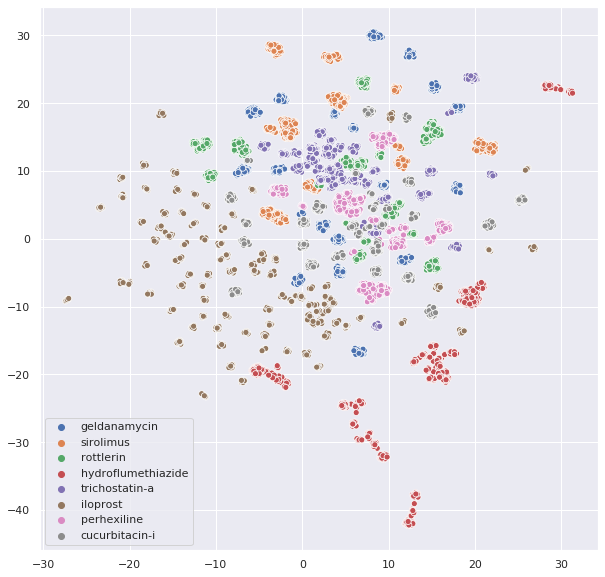

In [43]:
%matplotlib inline
plt.figure(figsize=(10,10))
sns.scatterplot(embeddings[:, 0], embeddings[:, 1], hue=y)
plt.savefig('fp_clustering.jpg')
plt.show()